In [ ]:
# git clone https://github.com/bharath5673/YOLOv8-3D.git
# conda create -n test python=3.10 -y
# conda activate test
# pip install tensorflow
# pip install ultralytics imgaug opencv-python

In [1]:
import os
import numpy as np
import cv2

In [2]:
VEHICLES = ["Car", "Truck", "Van", "Tram"]
yolo_classes = [
    "Pedestrian",
    "Cyclist",
    "Car",
    "motorcycle",
    "airplane",
    "Van",
    "train",
    "Truck",
    "boat",
]

In [3]:
label_dir = "../3D-detection/kitti/training/label_2/"
image_dir = "../3D-detection/kitti/training/image_2/"
calib_dir = "../3D-detection/kitti/training/calib/"

In [35]:
def img_to_3d_pt_fixed_y(proj_matrix, pt):
    # 画像座標系から3D座標系に変換
    assert len(pt) == 2
    # y座標を0に固定
    m = np.delete(proj_matrix, 1, axis=1)
    m = np.linalg.inv(m)
    pt = np.append(pt, 1)
    pt = np.dot(m, pt)
    pt = pt[:2] / pt[2]
    pt = np.insert(pt, 1, 0)
    return -pt


def calc_alpha(front_pt, back_pt, theta_ray):
    ry = -np.arctan2(front_pt[2] - back_pt[2], front_pt[0] - back_pt[0])
    # ryからalphaを求める
    alpha = ry - theta_ray
    # alphaを-πからπの範囲に収める
    if alpha < -np.pi:
        alpha += 2 * np.pi
    if alpha > np.pi:
        alpha -= 2 * np.pi
    return alpha


def calc_alpha_from_pts(proj_matrix, front_pt, back_pt, theta_ray):
    back_pt = img_to_3d_pt_fixed_y(proj_matrix, back_pt)
    front_pt = img_to_3d_pt_fixed_y(proj_matrix, front_pt)
    alpha = calc_alpha(front_pt, back_pt, theta_ray)
    return alpha

In [47]:
from libs.bbox3d_utils import (
    calc_location_,
    rotation_matrix,
    create_corners,
    project_3d_pt,
)


def _get_bottom_pts(cam_to_img, ry, dimension, center):
    """_summary_

    Args:
        img (_type_): _description_
        cam_to_img (_type_): _description_
        ry (_type_): _description_
        dimension (_type_): _description_
        center (_type_): _description_

    Returns:
        list(list[int]): list of 2D points of the bottom of the 3D box
        list(list[int]): list of 3D points of the bottom of the 3D box
        0 - 1
        |   |
        2 - 3
    """

    R = rotation_matrix(ry)
    corners = create_corners(dimension, location=center, R=R)

    box_3d = []
    for corner in corners:
        point = project_3d_pt(corner, cam_to_img)
        box_3d.append(point)

    return [box_3d[0], box_3d[1], box_3d[4], box_3d[5]], [
        corners[0],
        corners[1],
        corners[4],
        corners[5],
    ]


def get_pts_from_annotation(proj_matrix, box_2d, dimensions, ry, theta_ray):

    # the math! returns X, the corners used for constraint
    ry = ry - theta_ray
    location, X = calc_location_(dimensions, proj_matrix, box_2d, ry, theta_ray)
    orient = ry + theta_ray
    pts, pts_3d = _get_bottom_pts(proj_matrix, orient, dimensions, location)

    front = [(pts[0][0] + pts[1][0]) / 2, (pts[0][1] + pts[1][1]) / 2]
    back = [(pts[2][0] + pts[3][0]) / 2, (pts[2][1] + pts[3][1]) / 2]

    front_3d = [
        (pts_3d[0][0] + pts_3d[1][0]) / 2,
        (pts_3d[0][1] + pts_3d[1][1]) / 2,
        (pts_3d[0][2] + pts_3d[1][2]) / 2,
    ]
    back_3d = [
        (pts_3d[2][0] + pts_3d[3][0]) / 2,
        (pts_3d[2][1] + pts_3d[3][1]) / 2,
        (pts_3d[2][2] + pts_3d[3][2]) / 2,
    ]
    return [front, back], [front_3d, back_3d]

def normalize_angle_in_pi(angle):
    """
    Normalize angle in [-pi, pi]
    """
    while angle > np.pi:
        angle -= 2 * np.pi
    while angle < -np.pi:
        angle += 2 * np.pi
    return angle

In [48]:
# 元のコードは誤りがあるので修正

def _calc_theta_ray(img, box_2d, proj_matrix):
    """
    Calculate global angle of object, see paper
    """
    width = img.shape[1]
    # Angle of View: fovx (rad) => 3.14
    fovx = 2 * np.arctan(width / (2 * proj_matrix[0][0]))
    center = (box_2d[0] + box_2d[2]) / 2 # center = (box_2d[0] + box_2d[1]) / 2 から修正
    dx = center - (width / 2)

    mult = 1
    if dx < 0:
        mult = -1
    dx = abs(dx)
    angle = np.arctan((2 * dx * np.tan(fovx / 2)) / width)
    angle = angle * mult

    return angle

In [49]:
dic = {}

label_file = "000079.txt"
image_file = label_file.replace("txt", "png")

objects = []
for line in open(label_dir + label_file).readlines():
    line = line.strip().split(" ")
    truncated = np.abs(
        float(line[1])
    )  # 画像からはみ出しているかどうか（0: はみ出していない、1: はみ出している）
    occluded = np.abs(
        float(line[2])
    )  # 他の物体に隠れているかどうか（0: 隠れていない、1: 部分的に隠れている、2: 大部分が隠れている、3: 不明）

    if line[0] in VEHICLES:
        # カメラ中心と物体の中心の角度
        new_alpha = float(line[3])

        obj = {
            "name": line[0],  # Car, Van, Truck, Pedestrian, Person_sitting, Cyclist
            "image": image_file,
            "xmin": int(float(line[4])),  # 2D bounding box
            "ymin": int(float(line[5])),
            "xmax": int(float(line[6])),
            "ymax": int(float(line[7])),
            "dims": np.array(
                [float(number) for number in line[8:11]]
            ),  # 3D object dimensions: height, width, length
            "alpha": float(line[3]),  # Observation angle of object, ranging [-pi..pi]
            "ry": float(line[14]),  # Rotation around Y-axis
        }

        objects.append(obj)

theta_ray:  0.0877803319290663 5.029442543792963
alpha:  -1.45 -83.07888029396936
calculated alpha from 3D points:  -1.4377803319290663 -82.3787448864541
calculated alpha from img points:  -1.4336833444658952 -82.14400479609638


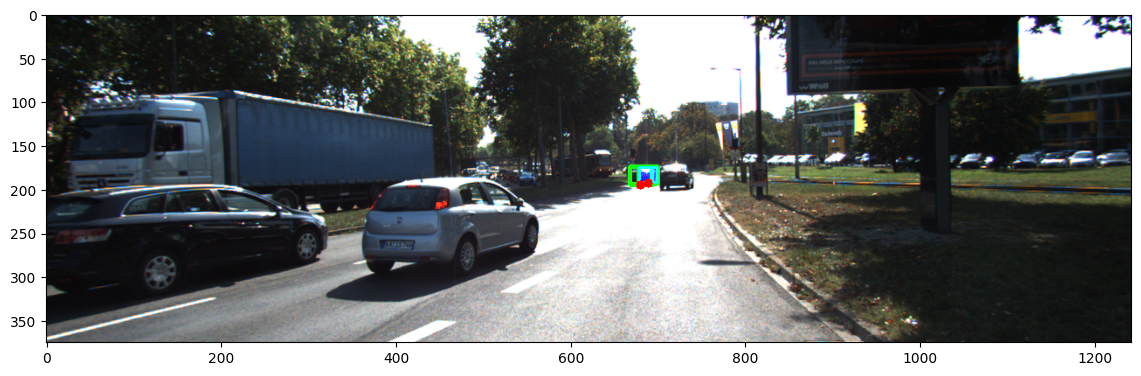

theta_ray:  -0.4890720050016603 -28.021761764596224
alpha:  2.18 124.90479933851947
calculated alpha from 3D points:  2.2690720050016604 130.00824929788277
calculated alpha from img points:  2.2545204924163613 129.17450904121364


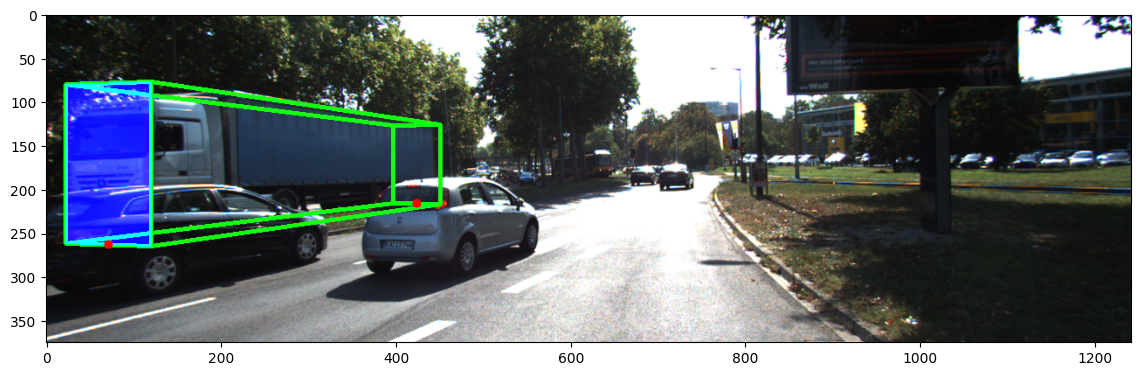

theta_ray:  0.13839546225146696 7.929475890771158
alpha:  -1.44 -82.50592249883854
calculated alpha from 3D points:  -1.4283954622514676 -81.8410314626474
calculated alpha from img points:  -1.4362844323206085 -82.2930361523142


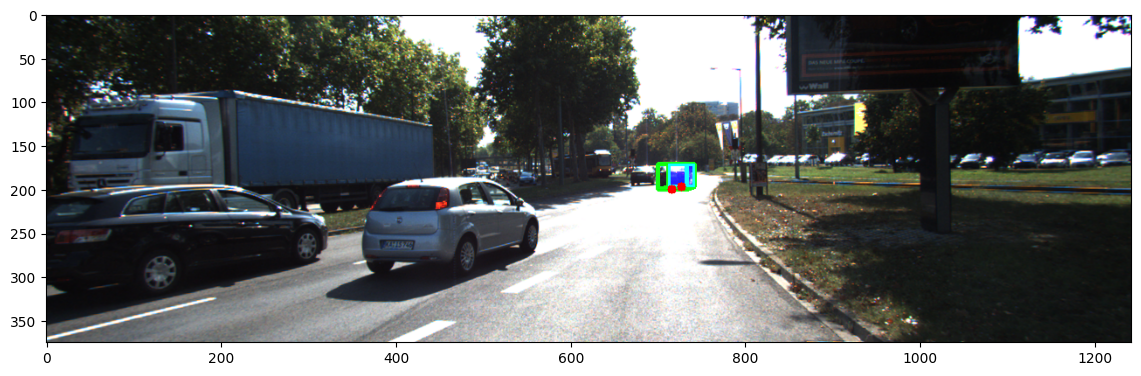

theta_ray:  -0.21689624002765578 -12.427239145841146
alpha:  -1.08 -61.879441874128915
calculated alpha from 3D points:  -1.043103759972344 -59.76544304064257
calculated alpha from img points:  -1.0455597323042634 -59.90615988986245


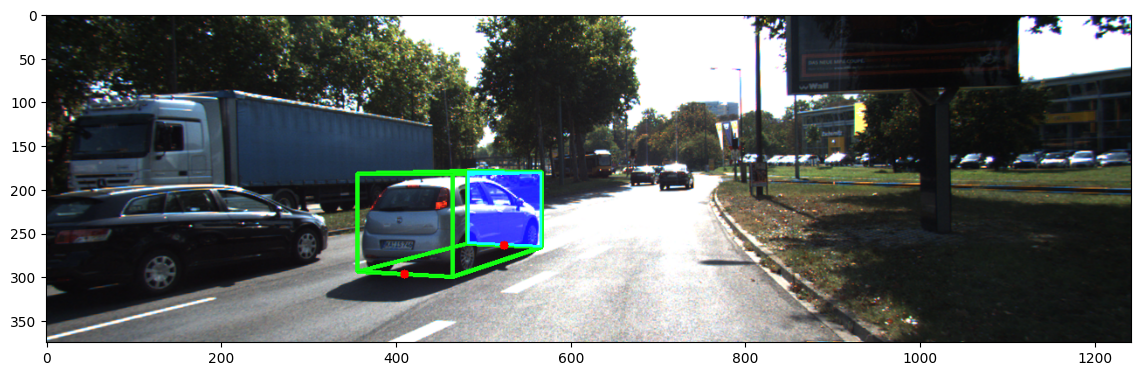

theta_ray:  -0.5655837457361766 -32.40556159188319
alpha:  -0.7 -40.10704565915762
calculated alpha from 3D points:  -0.6744162542638229 -38.641205004338865
calculated alpha from img points:  -0.6707140739043617 -38.42908569474551


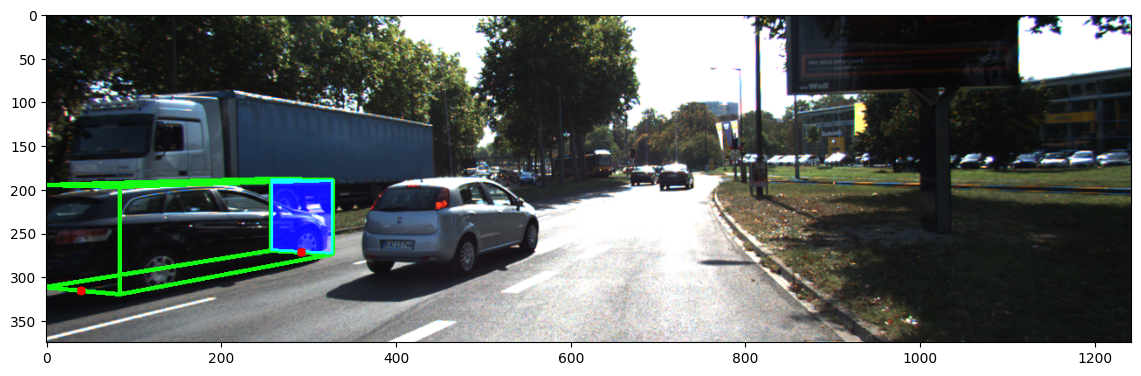

theta_ray:  -0.165477304364159 -9.48115114526807
alpha:  1.83 104.85127650894066
calculated alpha from 3D points:  1.8454773043641586 105.73806072724635
calculated alpha from img points:  1.8956270066924295 108.61142701449367


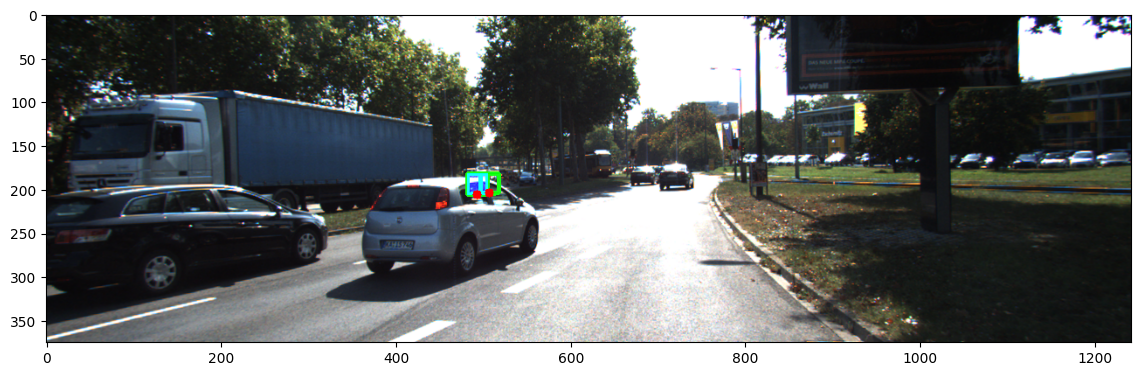

theta_ray:  -0.0013859280807286573 -0.07940782973441851
alpha:  1.22 69.90085100596043
calculated alpha from 3D points:  1.2313859280807284 70.55321663082566
calculated alpha from img points:  1.2262602072702726 70.25953446142417


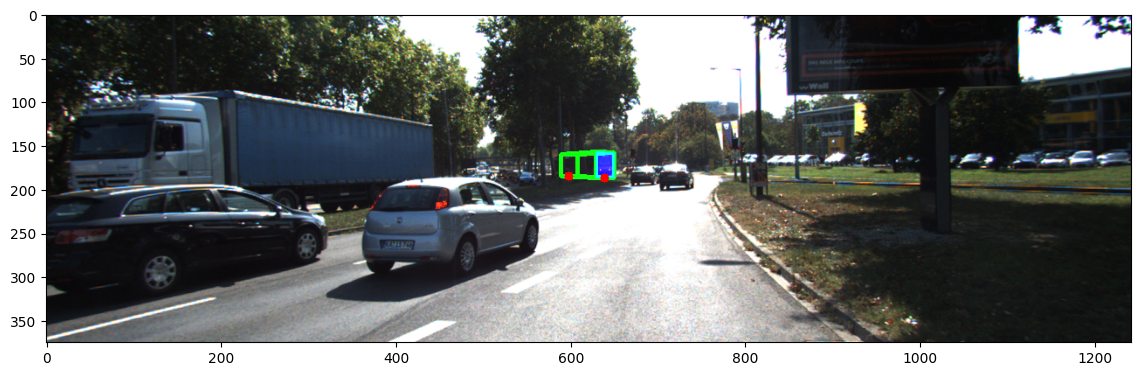

In [50]:
from libs.bbox3d_utils import (
    plot3d,
    get_calibration_cam_to_image,
)
import matplotlib.pyplot as plt

P2 = get_calibration_cam_to_image(calib_dir + image_file.replace("png", "txt"))
img = cv2.imread(image_dir + image_file)

for obj in objects:
    # # plot 2D bbox
    # _img = img.copy()
    # cv2.rectangle(
    #     _img, (obj["xmin"], obj["ymin"]), (obj["xmax"], obj["ymax"]), (0, 255, 0), 2
    # )
    # _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
    # fig = plt.figure(figsize=(14, 7))
    # ax = fig.subplots()
    # ax.imshow(_img)

    # plot 3D bbox
    _img2 = img.copy()
    bbox = np.array([obj["xmin"], obj["ymin"], obj["xmax"], obj["ymax"]])
    dim = obj["dims"]
    theta_ray = _calc_theta_ray(_img2, bbox, P2)
    ry = obj["ry"]
    alpha = ry - theta_ray
    alpha = normalize_angle_in_pi(alpha)
    plot3d(_img2, P2, bbox, dim, alpha, theta_ray)

    # traininng dataからalphaの計算に使う点を取得
    pts, pts_3d = get_pts_from_annotation(P2, bbox, dim, ry, theta_ray)
    # calculate alpha from 3D points
    alpha_3d = calc_alpha(pts_3d[0], pts_3d[1], theta_ray)
    cv2.circle(_img2, (int(pts[0][0]), int(pts[0][1])), 5, (0, 0, 255), -1)
    cv2.circle(_img2, (int(pts[1][0]), int(pts[1][1])), 5, (0, 0, 255), -1)

    # calculate alpha from img points
    alpha_img = calc_alpha_from_pts(P2, pts[0], pts[1], theta_ray)

    print("theta_ray: ", theta_ray, np.rad2deg(theta_ray))
    print("alpha: ", obj["alpha"], np.rad2deg(obj["alpha"]))
    print("calculated alpha from 3D points: ", alpha_3d, np.rad2deg(alpha_3d))
    print("calculated alpha from img points: ", alpha_img, np.rad2deg(alpha_img))

    _img2 = cv2.cvtColor(_img2, cv2.COLOR_BGR2RGB)

    fig2 = plt.figure(figsize=(14, 7))
    ax2 = fig2.subplots()
    ax2.imshow(_img2)
    plt.show()